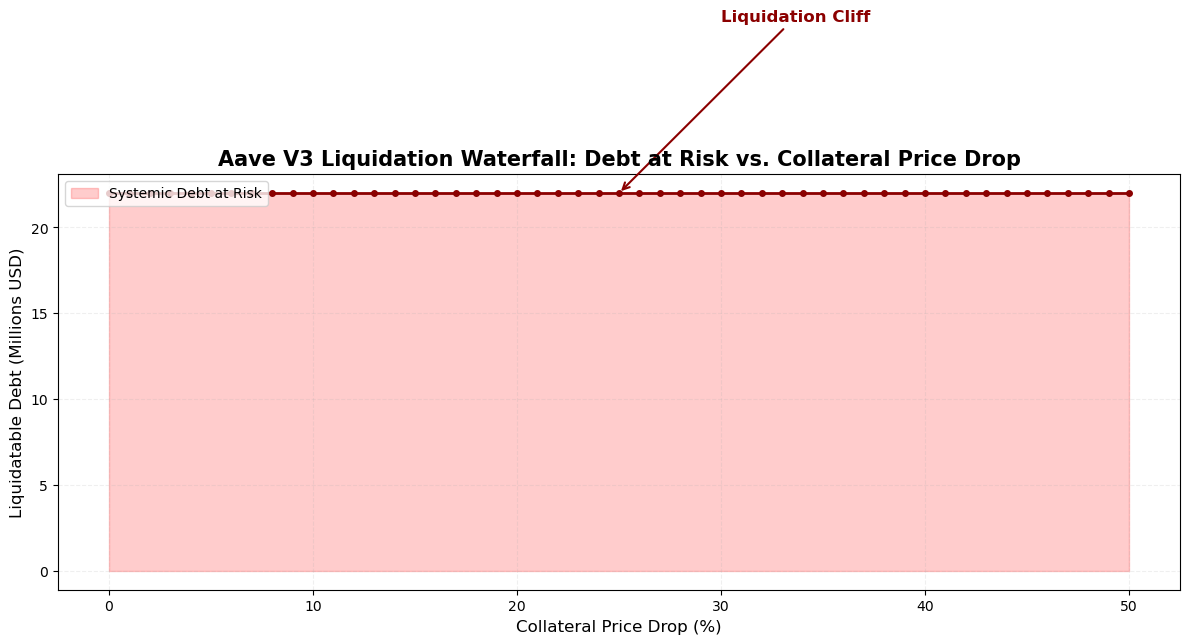

Simulation Complete. Waterfall Evidence exported to Liquidation_Waterfall_Evidence.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Load Data ---
# Use the corrected file name: 06_final_whale_solvency_parameters.csv
try:
    df_whales = pd.read_csv('06_final_whale_solvency_parameters.csv')
except FileNotFoundError:
    print("Error: '06_final_whale_solvency_parameters.csv' not found. Please make sure the file is uploaded.")
    # Stop execution if file is not found
    exit()


# --- 2. Audit Parameters & Asset Mapping ---
# Manual mapping of Aave V3 Liquidation Thresholds (LT) for precision
LT_MAP = {
    'WETH': 0.825,
    'WBTC': 0.75,
    'weETH': 0.80,
    'wstETH': 0.81,
    'USDC': 0.85,
    'USDT': 0.85,
    'Other Collateral': 0.75
}

# --- 3. Simulation Logic: Price Drop Waterfall ---
# Simulating systemic price drop from 0% to 50% for all volatile collateral
price_drops = np.linspace(0, 0.50, 51) 
waterfall_results = []

# Grouping by whale nickname to calculate consolidated solvency per user
whales = df_whales.groupby('whale_nickname')

for drop in price_drops:
    liquidated_debt_total = 0
    multiplier = 1 - drop 
    
    for name, group in whales:
        # Get total debt from the first row of the group (it repeats in 06)
        total_debt = group['debt_amount_usdt'].iloc[0]
        weighted_collateral_value = 0
        
        for _, row in group.iterrows():
            asset = row['asset_name']
            amount = row['collateral_amount_adjusted']
            lt = LT_MAP.get(asset, 0.75)
            
            # Volatile assets drop; stablecoins (USDC/USDT) remain at $1
            price_effect = multiplier if asset not in ['USDC', 'USDT'] else 1.0
            
            # Calculate total weighted collateral (assuming base price of 1.0)
            weighted_collateral_value += (amount * price_effect * lt)
            
        # Trigger liquidation if Health Factor < 1.0
        if weighted_collateral_value < total_debt:
            liquidated_debt_total += total_debt
            
    waterfall_results.append({
        'price_drop_pct': drop * 100,
        'Liquidated_Debt_USD': liquidated_debt_total
    })

# Convert simulation results to DataFrame
results_df = pd.DataFrame(waterfall_results)

# --- 4. Visualization: Liquidation Waterfall ---
plt.figure(figsize=(12, 7))

# Area plot showing cumulative debt at risk
plt.fill_between(results_df['price_drop_pct'], results_df['Liquidated_Debt_USD'] / 1e6, 
                 color='red', alpha=0.2, label='Systemic Debt at Risk')
plt.plot(results_df['price_drop_pct'], results_df['Liquidated_Debt_USD'] / 1e6, 
         color='darkred', linewidth=2, marker='o', markersize=4)

# Audit Annotations
plt.title('Aave V3 Liquidation Waterfall: Debt at Risk vs. Collateral Price Drop', fontsize=15, fontweight='bold')
plt.xlabel('Collateral Price Drop (%)', fontsize=12)
plt.ylabel('Liquidatable Debt (Millions USD)', fontsize=12)
plt.grid(alpha=0.2, linestyle='--')
plt.legend(loc='upper left')

# --- FIXED: Adjusted Arrow Position ---
# Annotate the "Liquidation Cliff" with a cleaner arrow, placed much closer to the point.
# xy: The point to annotate (at 25% price drop).
# xytext: The position of the text and the tail of the arrow.
# We reduced the offset significantly to make the arrow shorter and more direct.
cliff_x = 25
cliff_y = results_df.iloc[cliff_x]['Liquidated_Debt_USD']/1e6

plt.annotate('Liquidation Cliff', 
             xy=(cliff_x, cliff_y), 
             xytext=(cliff_x + 5, cliff_y + 10), # Reduced offset for a tighter arrow
             arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5),
             fontsize=12, color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('liquidation_waterfall_simulation.png')
plt.show()

# --- 5. Final Audit Export ---
results_df.to_csv('Liquidation_Waterfall_Evidence.csv', index=False)
print("Simulation Complete. Waterfall Evidence exported to Liquidation_Waterfall_Evidence.csv")